In [1]:
import pandas as pd
import numpy as np
from numpy import matlib as mb
from sklearn.linear_model import Lasso, lasso_path
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import sys
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# import data 

In [3]:
allfactors = pd.read_csv('factors.csv')

In [4]:
date = allfactors['Date']
rf = allfactors['RF']
factors = allfactors.iloc[:,2:].values

In [5]:
L = date.shape[0]
P = factors.shape[1]

In [6]:
# test portfolios
port_5x5 = pd.read_csv('port_5x5.csv', header=None)
port_3x2 = pd.read_csv('port_3x2.csv', header=None)
port_202 = pd.read_csv('port202.csv', header=None)

# excess return
port_5x5 = port_5x5.iloc[:,1:] - rf.values.reshape((rf.shape[0],1))@np.ones(shape=(1,port_5x5.shape[1]-1))
port_3x2 = port_3x2.iloc[:,1:] - rf.values.reshape((rf.shape[0],1))@np.ones(shape=(1,port_3x2.shape[1]-1))
port_202 = port_202.iloc[:,1:] - rf.values.reshape((rf.shape[0],1))@np.ones(shape=(1,port_202.shape[1]-1))

In [8]:
# other information
summary = pd.read_csv('summary.csv')
summary

,Row,ID,SR,Mean,tstat,Std,Year,Year_begin,Year_end,Descpription,Authors
0,MktRf,1,0.5057,0.0064,3.2580,0.0437,1972,1931.0,1965,Excess Market Return,Black and Jensen and Scholes
1,beta,2,-0.0538,-0.0008,-0.3468,0.0496,1973,1935.0,1968,Market Beta,Fama and Macbeth
2,ep,3,0.2970,0.0028,1.9134,0.0327,1977,1956.0,1971,Earnings to price,Basu
3,dy,4,0.0060,0.0001,0.0384,0.0404,1979,1952.0,1977,Dividend to price,Litzenberger and Ramaswamy
4,sue,5,0.2634,0.0012,1.6969,0.0161,1982,1971.0,1980,Unexpected quarterly earnings,Rendelman and Jones and Latane
...,...,...,...,...,...,...,...,...,...,...,...
145,CMA,146,0.4684,0.0026,3.0172,0.0195,2015,1963.0,2013,Conservative Minus Aggressive,Fama and French
146,HXZ_IA,147,0.6474,0.0034,4.1706,0.0183,2015,1972.0,2012,HXZ Investment,Hou and Xue and Zhang
147,HXZ_ROE,148,0.7746,0.0057,4.9901,0.0253,2015,1972.0,2012,HXZ Profitability,Hou and Xue and Zhang
148,Intermediary,149,0.0794,0.0015,0.5118,0.0658,2016,1970.0,2012,Intermediary Risk Factor,He and Kelly and Manela


In [9]:
factorname = summary['Row']
factorname_full = summary['Descpription']
year_pub = summary['Year']
year_end = summary['Year_end']

In [10]:
port_5x5_id = pd.read_csv('port_5x5_id.csv')
port_3x2_id = pd.read_csv('port_3x2_id.csv')

In [12]:
# form a smaller set of portfolios for bivariate sorted porfolios
kk = 10 # minimun number of stocks in a portfolio

include_3x2 = np.where(port_3x2_id['min_stk6'] >=kk)
include_3x2 = include_3x2[0].tolist() # tuple(array, ?) -> list로 변환
print("no of pf_3x2", len(include_3x2)*6)

for i in range(P):
    if i in include_3x2:
        if i == 0:
            port_3x2b = port_3x2.iloc[:,i*6:(i+1)*6]
        else:
            port_3x2b = port_3x2b.join(port_3x2.iloc[:,i*6:(i+1)*6])

include_5x5 = np.where(port_5x5_id['min_stk'] >=kk)
include_5x5 = include_5x5[0].tolist()
print("no of pf_5x5", len(include_5x5)*25)

for i in range(P):
    if i in include_5x5:
        if i == 0:
            port_5x5b = port_5x5.iloc[:,i*25:(i+1)*25]
        else:
            port_5x5b = port_5x5b.join(port_5x5.iloc[:,i*25:(i+1)*25])

no of pf_3x2 750
no of pf_5x5 1825


# Functions

In [13]:
def TSCV(Ri, gt, ht, lambda_, Kfld, Jrep, alpha=1, seednum=101):

    p, T = ht.shape
    LL3 = lambda_.shape[0]

    cvm3 = np.empty((LL3, Kfld, Jrep))
    cvm33 = []
    
    # finding NaN row index 
    hg = np.append(ht, gt, axis=0)
    nomissing = ~ (np.isnan(hg)).any(axis=0)
    ht = (hg[:,nomissing])[:-gt.shape[0],:]
    ht = ht.T # n' x p
    gt = (hg[:,nomissing])[-gt.shape[0]:,:]
    gt = gt.T # n' x d
    
    '''Using KFold'''
    for j in range(Jrep):
        
        # cross-validation
        kf = KFold(n_splits=Kfld, shuffle=True, random_state=seednum+j)
        k =0
        for train_index, test_index in kf.split(ht):
            ht_train, ht_test = ht[train_index,:], ht[test_index,:]
            gt_train, gt_test = gt[train_index,:], gt[test_index,:]

            # LASSO estimation w/ fit_intercept=False
            _, coefs_lasso, _ = lasso_path(ht_train, gt_train, alphas=lambda_, max_iter=1_000_000) 
            coefs_lasso = (np.array(coefs_lasso)).reshape((p, LL3)) # p x LL3
            
            # predicted gt
            gt_pred = ht_test @ coefs_lasso #(p x n').T x (p x LL3) = n' x LL3

            cvm3[0:LL3,k,j] = np.nanmean((mb.repmat(gt_test,1,LL3) - gt_pred)**2,0).T # LL3x1
            k+=1

    cvm33 = cvm3.reshape((cvm3.shape[0], cvm3.shape[1]*Jrep)) # Jrep =1
    cvm333 = np.mean(cvm33,1)
    l_sel3 = np.argmin(cvm333)

    cv_sd3 = np.std(cvm33.T, axis=0)/np.sqrt(Kfld*Jrep)
    cvm33ub = cvm333[l_sel3] + cv_sd3[l_sel3] # upper bound
    if (np.where(cvm333[:l_sel3] >= cvm33ub)[0]).shape[0] == 0: 
        l3_1se = l_sel3
    else:
        l3_1se = (np.where(cvm333[:l_sel3] >= cvm33ub)[0])[-1]

    # to reestimate the model with all data
    # refit the model
    model3 = Lasso(alpha=lambda_[l_sel3], max_iter=1_000_000)
    model3.fit(ht, gt) # nomissing: n x 1 

    # select non-zero coef. index
    sel3 = (np.where(model3.coef_ !=0))[0] # except constant term 
    sel3 = sel3.astype(int)

    model3_1 = Lasso(alpha=lambda_[l3_1se], max_iter=1_000_000)
    model3_1.fit(ht, gt)

    sel3_1se = (np.where(model3_1.coef_ !=0))[0]
    sel3_1se = sel3_1se.astype(int)

    return dict({'sel3':sel3, 'lambda3':lambda_[l_sel3], 'sel3_1se':sel3_1se, 'lambda3_1se':lambda_[l3_1se]})

In [14]:
def infer(Ri, gt, ht, sel1, sel2, sel3):

    n = Ri.shape[0]
    p = ht.shape[0]
    d = gt.shape[0]

    tot1 = np.append(gt.T, Ri.T, axis=1)
    tmp1_pd = pd.DataFrame(tot1).dropna().cov() 
    cov_g = tmp1_pd.values[d:,:d]

    tot2 = np.append(ht.T, Ri.T, axis=1)
    tmp2_pd = pd.DataFrame(tot2).dropna().cov()
    cov_h = tmp2_pd.values[p:,:p]

    ER  = np.mean(Ri, axis=1) 
    ER = ER.values 

    select = np.union1d(sel1,sel2)

    # projection matrix of one-vector
    one_vec = np.ones((n,1))
    M0 = np.eye(n) - one_vec@ np.linalg.inv(one_vec.T@one_vec)@one_vec.T

    # eliminate rows with missing values
    hg = np.append(ht, gt, axis=0)
    nomissing = np.where((np.isnan(hg)).any(axis=0) == False)[0]

    Lnm = nomissing.shape[0]

    cov_h_sel = cov_h[:, select.astype(int)]

    # partition regression w/o constant term
    X = np.append(cov_g, cov_h_sel, axis=1)
    lambda_full = np.linalg.inv(X.T@M0@X) @ (X.T@M0@ER)
    lambdag = lambda_full[0:d]

    ht_sel = (ht[sel3, :])[:,nomissing] # ht select (by sel3) & nomiss
    gt_ = gt[:, nomissing]              #gt nomiss

    # For double selection inference: AVAR
    zhat = np.empty((d,Lnm))

    for i in range(d):
        M_mdl = np.eye(Lnm) - ht_sel.T @ np.linalg.inv(ht_sel@ht_sel.T) @ ht_sel
        zhat[i,:] = (M_mdl @ gt_.T).reshape((M_mdl.shape[0],)) # (I-P)g

    Sigmazhat = (zhat @ zhat.T)/Lnm # RSS, scalar

    temp2 = np.zeros((d,d))

    ht_select = ht[select.astype(int),:]

    for ii, l in enumerate(nomissing):
        mt = 1 - lambda_full.T @ (np.append(gt[0:d,l], ht_select[:,l], axis=0)).reshape((-1,1)) 
        temp2 += (mt**2) @ (np.linalg.inv(Sigmazhat) @ zhat[:,ii].reshape(-1,1) @ zhat[:,ii].reshape(1,-1) @ np.linalg.inv(Sigmazhat))

    avar_lambdag = np.diag(temp2)/Lnm
    se = np.sqrt(avar_lambdag/Lnm)

    ht_select_no = (ht[select.astype(int), :])[:,nomissing]

    # scaled lambda for DS
    vt = np.append(gt_, ht_select_no, axis=0)
    V_bar = vt - (np.mean(vt, axis=1)).reshape((-1,1)) @ np.ones((1,Lnm))
    var_v = (V_bar @ V_bar.T)/Lnm # deviated from mean
    gamma = np.multiply(np.diag(var_v), lambda_full) 

    return dict({ 'lambdag':lambdag, 'se':se, 'gamma':gamma })

In [15]:
def DS(Ri, gt, ht, tune1, tune2, alpha=1, seednum=101):
    # alpha =1: default is lasso
    
    # data information
    n = Ri.shape[0] # 750
    p = ht.shape[0] # 135
    d = gt.shape[0] # 1

    tot1 = np.append(gt.T, Ri.T, axis=1)
    tmp1_pd = pd.DataFrame(tot1).dropna().cov() 
    cov_g = tmp1_pd.values[d:,:d]
    tot2 = np.append(ht.T, Ri.T, axis=1)
    tmp2_pd = pd.DataFrame(tot2).dropna().cov()
    cov_h = tmp2_pd.values[p:,:p]
  
    ER  = np.mean(Ri, axis=1) # mean of portfolio returns
    ER = ER.values
    
    # penaltize; see Bryzgalova (2015)
    beta = np.empty((n,p))
    '''ddof: default value is 0 in numpy, but 1 in matlab'''
    for i in range(p):
        beta[:,i] = cov_h[:,i]/np.nanvar(ht[i,:], ddof=1)
    penalty = np.nanmean(beta**2, axis=0) 
    penalty = penalty/np.nanmean(penalty) # normalize
    
    lambda0 = np.exp(np.linspace(0,-35,100)) # penalty parameter array
    
    '''1st selection'''
    model1 = Lasso(alpha=np.exp(-tune1), max_iter=1_000_000, tol=1e-7)
    model1.fit(cov_h@(np.diag(penalty)), ER) # cov_h@(np.diag(penalty)) = [h1 h2 ...] @ diag([p1 p2 ...]) = [p1h1 p2h1 ...]
    model1_est = np.append(model1.intercept_, model1.coef_) 

    sel1 = (np.where(model1_est[1:p+2]!=0))[0]
    
    # get RSS of model 1
    y_hat_1 = np.append(np.ones((n,1)), cov_h@(np.diag(penalty)), axis=1)
    beta_hat_1 = model1_est.reshape((-1,1))
    err1 = np.mean( (ER - y_hat_1@beta_hat_1)**2 )
    
    '''2nd selection'''
    sel2 = np.array([])
    err2 = np.empty((d,1))
    for i in range(d): # d=1
        model2 = Lasso(alpha=np.exp(-tune2), max_iter=1_000_000, tol=1e-7)
        model2.fit(cov_h@(np.diag(penalty)), cov_g[:,i])
        model2_est = np.append(model2.intercept_, model2.coef_)
        sel2_temp = (np.where(model2_est[1:p+2]!=0))[0]
        sel2 = np.concatenate((sel2, sel2_temp))

        # get RSS of model 2
        y_hat_2 = np.append(np.ones((n,1)), cov_h@(np.diag(penalty)), axis=1)
        beta_hat_2 = model2_est.reshape((-1,1))
        err1 = np.mean( (cov_g[:,i] - y_hat_2@beta_hat_2)**2 )
    sel2 = np.unique(sel2).T

    '''3rd selection'''
    sel3 = np.array([])
    for i in range(d):
        TSCVout = TSCV(Ri, gt[i,:].reshape(1,-1) , ht, lambda0, 10, 1)
        sel3 = np.concatenate((sel3, TSCVout['sel3_1se']))        
    sel3 = np.unique(sel3)
    sel3 = sel3.astype(int)
    
    '''post selection estimation and inference'''
    dsout = infer(Ri, gt, ht, sel1, sel2, sel3)
    ssout = infer(Ri, gt, ht, sel1, np.array([]), sel3)
    
    '''return'''
    return_dict = dict({
        # return for DS
        'lambdag_ds':dsout['lambdag'],
        'se_ds':dsout['se'],
        'gamma_ds':dsout['gamma'],
        # return for SS
        'lambdag_ss':ssout['lambdag'],
        'se_ss':ssout['se'],
        'gamma_ss':ssout['gamma'],
        # selection return
        'sel1':sel1,
        'sel2':sel2,
        'sel3':sel3,
        'select':np.union1d(sel1,sel2),
        'err1':err1,
        'err2':err2
    })
    return return_dict

In [16]:
def PriceRisk_OLS(Ri, gt, ht):
    n, T = Ri.shape
    d = gt.shape[0]
    p = ht.shape[0]

    np_Ri = Ri.values

    cov_h = np.empty((n,p))
    for nn in range(n):
        Rh = np.append((np_Ri[nn,:]).reshape(-1,1), ht.T, axis=1) # T x 1 + T x p 
        Rh_cov = pd.DataFrame(Rh).dropna().cov()
        cov_h[nn, :] = Rh_cov.values[0, 1:]

    cov_g = np.empty((n,d))
    for nn in range(n):    
        Rg = np.append((np_Ri[nn,:]).reshape(-1,1), gt.T, axis=1) # T x 1 + T x d
        Rg_cov = pd.DataFrame(Rg).dropna().cov()
        cov_g[nn, :] = Rg_cov.values[0, 1:]

    ER  = np.mean(Ri, axis=1)
    ER = ER.values
    
    one_vec = np.ones((n,1))
    M0 = np.eye(n) - one_vec@ np.linalg.inv(one_vec.T@one_vec)@one_vec.T

    # For no selection OLS
    X = np.append(cov_g, cov_h, axis=1)
    X_zero = np.append(np.ones((n,1)), X, axis=1)
    lambda_full_zero = np.linalg.inv(X_zero.T@X_zero) @ (X_zero.T @ ER)
    lambda_full = np.linalg.inv(X.T@M0@X) @ (X.T@M0@ER)
    lambdag_ols = lambda_full[0:d]

    # eliminate rows with missing values
    hg = np.append(ht, gt, axis=0)
    nomissing = np.where((np.isnan(hg)).any(axis=0) == False)[0]
    Lnm = nomissing.shape[0]

    # calculate avar_ols
    zhat = np.empty((d,Lnm))

    for i in range(d):
        M_mdl = np.eye(Lnm) - ht[:,nomissing].T @ np.linalg.inv(ht[:,nomissing]@ht[:,nomissing].T) @ ht[:,nomissing]
        zhat[i,:] = (M_mdl @ gt[i,nomissing].T).reshape((-1,))

    Sigmazhat = (zhat @ zhat.T)/Lnm

    temp3 = np.zeros((d,d))

    for ii, l in enumerate(nomissing):
        mt = 1 - lambda_full.T @ (np.append(gt[:,l], ht[:,l], axis=0)).reshape((-1,1)) 
        temp3 += (mt**2) @ (np.linalg.inv(Sigmazhat) @ zhat[:,ii].reshape(-1,1) @ zhat[:,ii].reshape(1,-1) @ np.linalg.inv(Sigmazhat))

    avar_lambdag3 = np.diag(temp3)/Lnm
    se3 = np.sqrt(avar_lambdag3/Lnm)

    # scaled lambda for DS
    vt = np.append(gt[:,nomissing], ht[:,nomissing], axis=0)
    V_bar = vt - (np.mean(vt, axis=1)).reshape((-1,1)) @ np.ones((1,Lnm))
    var_v = (V_bar @ V_bar.T)/Lnm
    lambda_ols = np.multiply(np.diag(var_v), lambda_full) 
    
    return_dict = dict({
        'lambdag_ols': lambdag_ols,
        'se_ols': se3,
        'lambda_ols': lambda_ols,
        'lambda_ols_zero': lambda_full_zero
    })
    
    return return_dict

# Main results

## Table 1

In [ ]:
Ri = port_3x2b

mkt_ind = int((np.where(factorname == 'MktRf'))[0]) #0
smb_ind = int((np.where(factorname == 'SMB'))[0]) #20
hml_ind = int((np.where(factorname == 'HML'))[0]) #21

# choose control factors before 2012
ContrlList = np.where(year_pub < 2012)
ContrlList = ContrlList[0].tolist()
ControlFactor = factors[:, ContrlList]
FF3 = factors[:,[mkt_ind,smb_ind,hml_ind]].T

# test factors since 2012
TestList = np.where(year_pub >= 2012)
TestList = TestList[0].tolist()
TestFactor = factors[:, TestList]

In [18]:
tune_center = pd.read_excel('tune_center.xlsx', header=None)
tune_center = tune_center.values

In [ ]:
result_table = np.empty((len(TestList), 8))

for j in range(len(TestList)):
    gt = TestFactor[:,j].reshape(1,-1)
    ht = ControlFactor.T
    
    print(j, factorname_full[j+ht.shape[0]])
    
    # use the average tuning parameter from 200 randome seeds
    model_ds = DS(Ri.T, gt, ht, -np.log(tune_center[j,0]), -np.log(tune_center[j,1]))
    tstat_ds = model_ds['lambdag_ds']/model_ds['se_ds']
    lambda_ds = model_ds['gamma_ds'][0]
    
    # Single-Selection results, replace with a huge tune2
    model_ss = DS(Ri.T, gt, ht, -np.log(tune_center[j,0]), -np.log(1))
    tstat_ss = model_ss['lambdag_ss']/model_ss['se_ss']
    lambda_ss = model_ss['gamma_ss'][0]

    # only control FF3 by OLS
    model_FF3 = PriceRisk_OLS(Ri.T, gt, FF3)
    tstat_FF3 = model_FF3['lambdag_ols']/model_FF3['se_ols']
    lambda_FF3 = model_FF3['lambda_ols'][0]

    # controlling everything, no selection, OLS
    model_ols = PriceRisk_OLS(Ri.T, gt, ht)
    tstat_ols = model_ols['lambdag_ols']/model_ols['se_ols']
    lambda_ols = model_ols['lambda_ols'][0]
    
    result_table[j,:] = np.array([lambda_ds*10000, tstat_ds[0,], lambda_ss*10000, tstat_ss[0,], lambda_FF3*10000, tstat_FF3[0,], lambda_ols*10000, tstat_ols[0,]])
    print(lambda_ds, tstat_ds[0,], '\n', lambda_ss, tstat_ss[0,], '\n',lambda_FF3, tstat_FF3[0,], '\n', lambda_ols, tstat_ols[0,])

## issue: tolerance 

In [20]:
def DS_2(Ri, gt, ht, tune1, tune2, tol_2nd, sel3, alpha=1, seednum=101):
    ''' add these parameters: tol_2nd & sel3 '''
    
    # data information
    n = Ri.shape[0] # 750
    p = ht.shape[0] # 135
    d = gt.shape[0] # 1

    tot1 = np.append(gt.T, Ri.T, axis=1)
    tmp1_pd = pd.DataFrame(tot1).dropna().cov() # 1x498 750x498 -> 751x751
    cov_g = tmp1_pd.values[d:,:d]
    tot2 = np.append(ht.T, Ri.T, axis=1)
    tmp2_pd = pd.DataFrame(tot2).dropna().cov() # 135x498 750x498 -> 885 x 885
    cov_h = tmp2_pd.values[p:,:p]

    ER  = np.mean(Ri, axis=1)
    ER = ER.values
    
    beta = np.empty((n,p))
    for i in range(p):
        beta[:,i] = cov_h[:,i]/np.nanvar(ht[i,:], ddof=1)
    penalty = np.nanmean(beta**2, axis=0)
    penalty = penalty/np.nanmean(penalty) # normalize
    
    lambda0 = np.exp(np.linspace(0,-35,100)) # penalty parameter array
    
    '''1st selection'''
    model1 = Lasso(alpha=np.exp(-tune1), max_iter=10_000_000)
    model1.fit(cov_h@(np.diag(penalty)), ER) #cov_h@(np.diag(penalty)) vs aaa
    model1_est = np.append(model1.intercept_, model1.coef_) 
    sel1 = (np.where(model1_est[1:p+2]!=0))[0]
    # get RSS of model 1
    y_hat_1 = np.append(np.ones((n,1)), cov_h@(np.diag(penalty)), axis=1)
    beta_hat_1 = model1_est.reshape((-1,1))
    err1 = np.mean( (ER - y_hat_1@beta_hat_1)**2 )

    '''2nd selection'''
    sel2 = np.array([])
    err2 = np.empty((d,1))
    for i in range(d): # d=1
        model2 = Lasso(alpha=np.exp(-tune2), max_iter=10_000_000, tol=tol_2nd)
        model2.fit(cov_h@(np.diag(penalty)), cov_g[:,i])
        model2_est = np.append(model2.intercept_, model2.coef_)
        sel2_temp = (np.where(model2_est[1:p+2]!=0))[0]
        sel2 = np.concatenate((sel2, sel2_temp))
        # get RSS of model 2
        y_hat_2 = np.append(np.ones((n,1)), cov_h@(np.diag(penalty)), axis=1)
        beta_hat_2 = model2_est.reshape((-1,1))
        err1 = np.mean( (cov_g[:,i] - y_hat_2@beta_hat_2)**2 )
    sel2 = np.unique(sel2).T
    
    '''post selection estimation and inference'''
    dsout = infer(Ri, gt, ht, sel1, sel2, sel3)
    ssout = infer(Ri, gt, ht, sel1, np.array([]), sel3)
    
    '''return'''
    return_dict = dict({
        # return for DS
        'lambdag_ds':dsout['lambdag'],
        'se_ds':dsout['se'],
        'gamma_ds':dsout['gamma'],
        # return for SS
        'lambdag_ss':ssout['lambdag'],
        'se_ss':ssout['se'],
        'gamma_ss':ssout['gamma'],
        # selection return
        'sel1':sel1,
        'sel2':sel2,
        'sel3':sel3,
        'select':np.union1d(sel1,sel2),
        'err1':err1,
        'err2':err2
    })
    return return_dict

In [ ]:
# show the results varying with tolerance parameter in Scikit-learn
for j in range(len(TestList)):
    gt = TestFactor[:,j].reshape(1,-1)
    ht = ControlFactor.T

    model_ds = DS(Ri.T, gt, ht, -np.log(tune_center[j,0]), -np.log(tune_center[j,1]))
    sel3 = model_ds['sel3']
    
    print(j, factorname_full[j+ht.shape[0]])
    for tt in (10 ** np.arange(-2,-9, -0.1)):
        # use the average tuning parameter from 200 randome seeds
        model_ds = 0
        model_ds = DS_2(Ri.T, gt, ht, -np.log(tune_center[j,0]), -np.log(tune_center[j,1]), tol_2nd=tt, sel3=sel3)
        tstat_ds = model_ds['lambdag_ds']/model_ds['se_ds']
        lambda_ds = model_ds['gamma_ds'][0]
        print(round(np.log10(tt),4), round(lambda_ds,7), round(tstat_ds[0,],7))

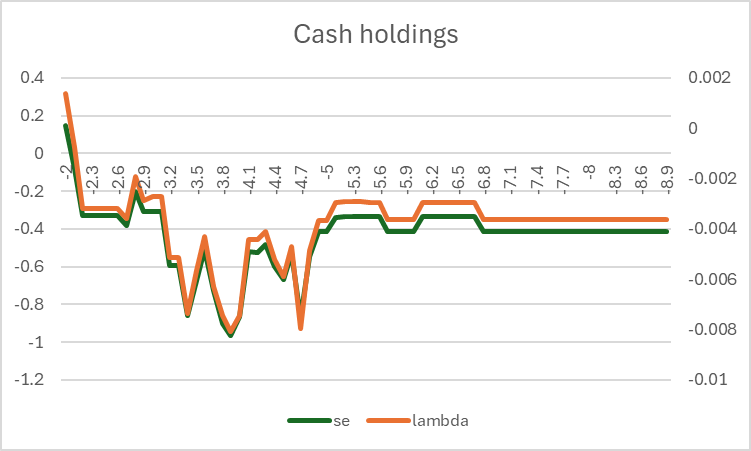
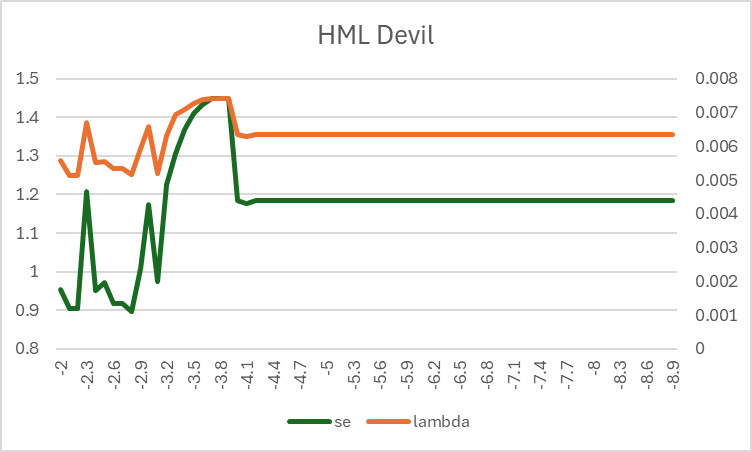

The results in Table 1 is similar with the results under tolerance with -2 ~ -3 using the SKlearn.\
However, the values are unstable, and they eventually get stable under the sufficiently low tolerance.

## heatmap
using the *DS_2* function: set tol_2nd as 1e-3

In [ ]:
# range of penalty
lambda1 = np.exp(np.arange(-24, -12, 0.5)) 
lambda2 = np.exp(np.arange(-33, -17, 0.5)) 

In [ ]:
# NaN 3D array
temp = 1
result_heatmap = np.empty((lambda1.shape[0],lambda2.shape[0], len(TestList)))
result_heatmap[:,:,:] = np.nan

ht = ControlFactor.T
for j in range(len(TestList)):
    gt = TestFactor[:,j].reshape(1,-1)
    print('\n', j, factorname_full[j+ht.shape[0]]) # show the testfactor which is being analyzed

    # finding the given 3rd selection (for time-keeping)
    model_ds = DS(Ri.T, gt, ht, -np.log(tune_center[j,0]), -np.log(tune_center[j,1]))
    sel3 = model_ds['sel3']
    print('done sel3')

    for l1_ind, l1 in enumerate(lambda1):
        for l2_ind, l2 in enumerate(lambda2):
            # calculate tstat_ds
            tstat_ds = np.nan # reset the var.
            model_ds = DS_2(Ri.T, gt, ht, -np.log(l1), -np.log(l2), tol_2nd=1e-3, sel3=sel3)
            tstat_ds = model_ds['lambdag_ds']/model_ds['se_ds']

            # insert into the 3D array
            result_heatmap[l1_ind,l2_ind,j] = tstat_ds

            # show the iteration state
            l1_per = l1_ind/lambda1.shape[0]
            l2_per = l2_ind/lambda2.shape[0]
            sys.stdout.write("\r")
            sys.stdout.write("l1 {:.2f}, l2 {:.2f}, tstat {:.2f}".format(l1_per, l2_per, result_heatmap[l1_ind,l2_ind,j]))
            sys.stdout.flush()

In [ ]:
result_heatmap_flat = np.empty((lambda1.shape[0] * len(TestList), lambda2.shape[0]))
result_heatmap_flat[:,:] = np.nan
for j in range(result_heatmap.shape[2]):
    result_heatmap_flat[lambda1.shape[0]*j:lambda1.shape[0]*(j+1),:] = result_heatmap[:,:,j]

In [ ]:
# save
(pd.DataFrame(result_heatmap_flat.T)).to_excel('result_heatmap.xlsx', index=False)
# load
result = pd.read_excel('result_heatmap.xlsx', header=None)

In [ ]:
result.index = np.round(np.log(lambda2), 3) 
result.columns = np.round(np.log(lambda1), 3)

In [ ]:
sns.heatmap( result, annot=False, cmap='viridis', cbar=True, vmin=-2, vmax=2) # 색방향 반대로 하려면 _r 붙이기
plt.xlabel('penalty for 1st')
plt.ylabel('penalty for 2nd')
plt.show()

replicated result of *Cash holdings*\
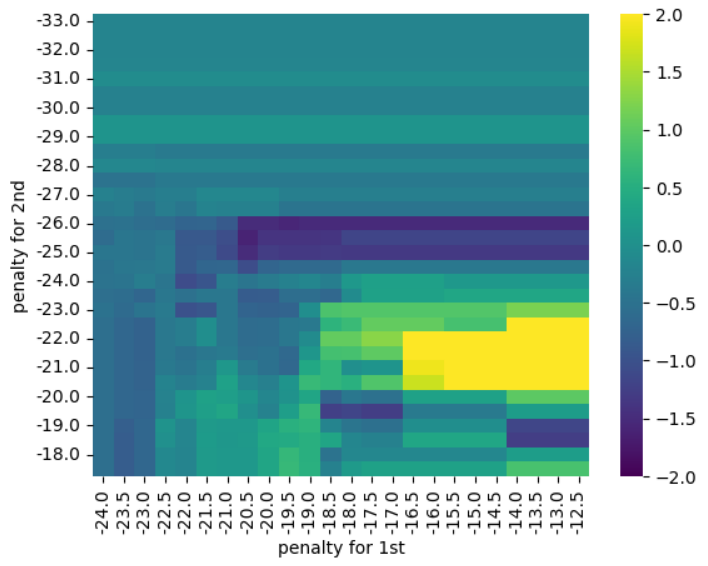

original resuls of that\
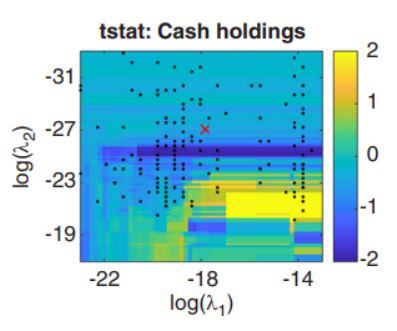

## Figure 1

In [ ]:
tune_sel_150 = pd.read_excel('tune_sel_150.xlsx', header=None)
tune_sel_150 = tune_sel_150.values

In [ ]:
sel11 = np.zeros((200,135))

for k in range(200):
    ht = ControlFactor.T # control factor
    
    n = Ri.shape[0]
    p = ht.shape[0]

    tot2 = np.append(ht.T, Ri.T, axis=1)
    tmp2_pd = pd.DataFrame(tot2).dropna().cov() 
    cov_h = tmp2_pd.values[p:,:p] 

    ER  = np.mean(Ri, axis=1)
    ER = ER.values

    # LASSO 
    model1 = Lasso(alpha=tune_sel_150[k,0], max_iter=1_000_000)
    model1.fit(cov_h@(np.diag(penalty)), ER)
    model1_est = np.append(model1.intercept_, model1.coef_) 

    sel1 = (np.where(model1_est[1:p+2]!=0))[0]  # constant 제외, p=135

    # select된 factor는 1로 표기
    for _ in range(p):
        if _ in sel1:
            sel11[k,_] = 1
    
    # show the iteration state
    sys.stdout.write("\r")
    sys.stdout.write("no of k: {}".format(k))
    sys.stdout.flush()

In [ ]:
sel11_sel_rate = np.mean(sel11, axis=0)

In [ ]:
plt.bar(np.arange(135), sel11_sel_rate)
plt.show()

replicated result:\
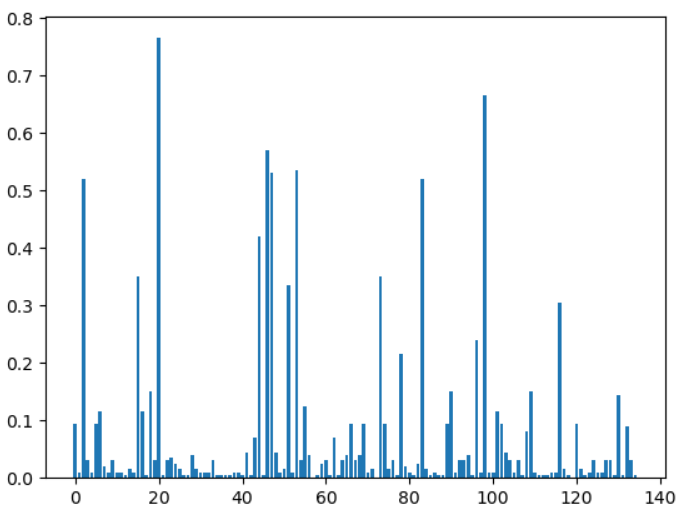

original result:\
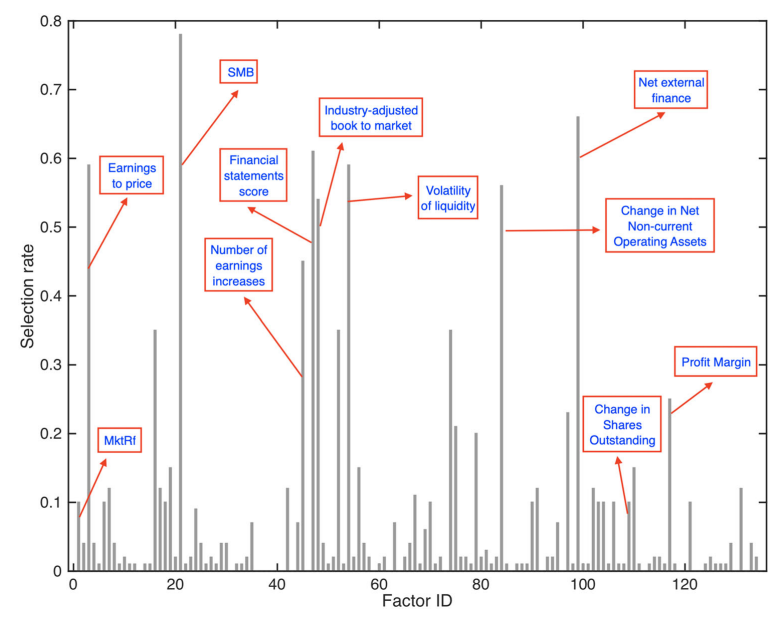

In [ ]:
df_sel11 = pd.DataFrame([np.array(factorname_full[:p]),sel11_sel_rate], index=['name','select'])
df_sel11 = df_sel11.T
df_sel11.set_index(['name'], inplace=True)
df_sel11.sort_values(by=['select'], ascending=False).head(20)